Data fields

1. Most of the fields are self-explanatory. The following are descriptions for those that aren't.

    - Id - an Id that represents a (Store, Date) duple within the test set
    
    - Store - a unique Id for each store
    - Sales - the turnover for any given day (this is what you are predicting)
    - Customers - the number of customers on a given day
    - Open - an indicator for whether the store was open: 0 = closed, 1 = open
    - StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on - public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
    - SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
    - StoreType - differentiates between 4 different store models: a, b, c, d
    - Assortment - describes an assortment level: a = basic, b = extra, c = extended
    - CompetitionDistance - distance in meters to the nearest competitor store
    - CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
    - Promo - indicates whether a store is running a promo on that day
    - Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    - Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
    - PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means - each round starts in February, May, August, November of any given year for that store


In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display  import HTML

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 20
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_stores_raw = pd.read_csv('store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store') 

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
490703,889,5,2014-04-18,0,0,0,1,b,0,d,a,18670.0,12.0,2005.0,0,NaN,NaN,NaN


## DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## RENOMEANDO COLUNAS

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

#função p/ transformar os espaços nos nomes em underline
snakecase = lambda x: inflection.underscore(x).lower()

#nova lista trocando o nome old pelo new
cols_new = list(map(snakecase, cols_old))

#rename old columns
df1.columns = cols_new

1 - DIMENSÃO DADOS

In [8]:
print('number of rows: {}'.format(df1.shape[0]))
print('number of cols: {}'.format(df1.shape[1]))

number of rows: 1017209
number of cols: 18


2 - TIPO DE DADOS

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
#transformando date
df1['date'] = pd.to_datetime(df1['date'])

3 - CHECK NaN

In [11]:
#porcentagem de valores nulos de uma coluna
(df1.isna().sum() / df1.shape[0]) * 100

store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.259730
competition_open_since_month    31.787764
competition_open_since_year     31.787764
promo2                           0.000000
promo2_since_week               49.943620
promo2_since_year               49.943620
promo_interval                  49.943620
dtype: float64

## TRATANDO VALORES NULOS

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competiton_distance
#20000 - corresponde a um valor muito maior que o maximo, apenas para servir de outlier
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
#extraindo mes
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
#extraindo ano
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
#extraindo ano
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [14]:
#promo_interval
month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

#substituindo nulos por '0'
df1['promo_interval'].fillna(0,inplace=True)

#criando novas colunas p/ numero de mes ser substituido por nome do mes
df1['month_map'] = df1['date'].dt.month.map(month_map)

#coluna que descreve se a loja entrou em uma 2 promoção
#CONDIÇÕES:
#0 se o valor já for zero
#1 se existir (month_map) no (promo_interval)
#0 se não existir (month_map) no (promo_interval)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [15]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [16]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


## CHANGE TYPES

In [17]:
#change types
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

#int32 para int64
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## DESCRIPTIVE STATISTICAL

In [26]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [34]:
m = num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [35]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


c:\Users\Cliente\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

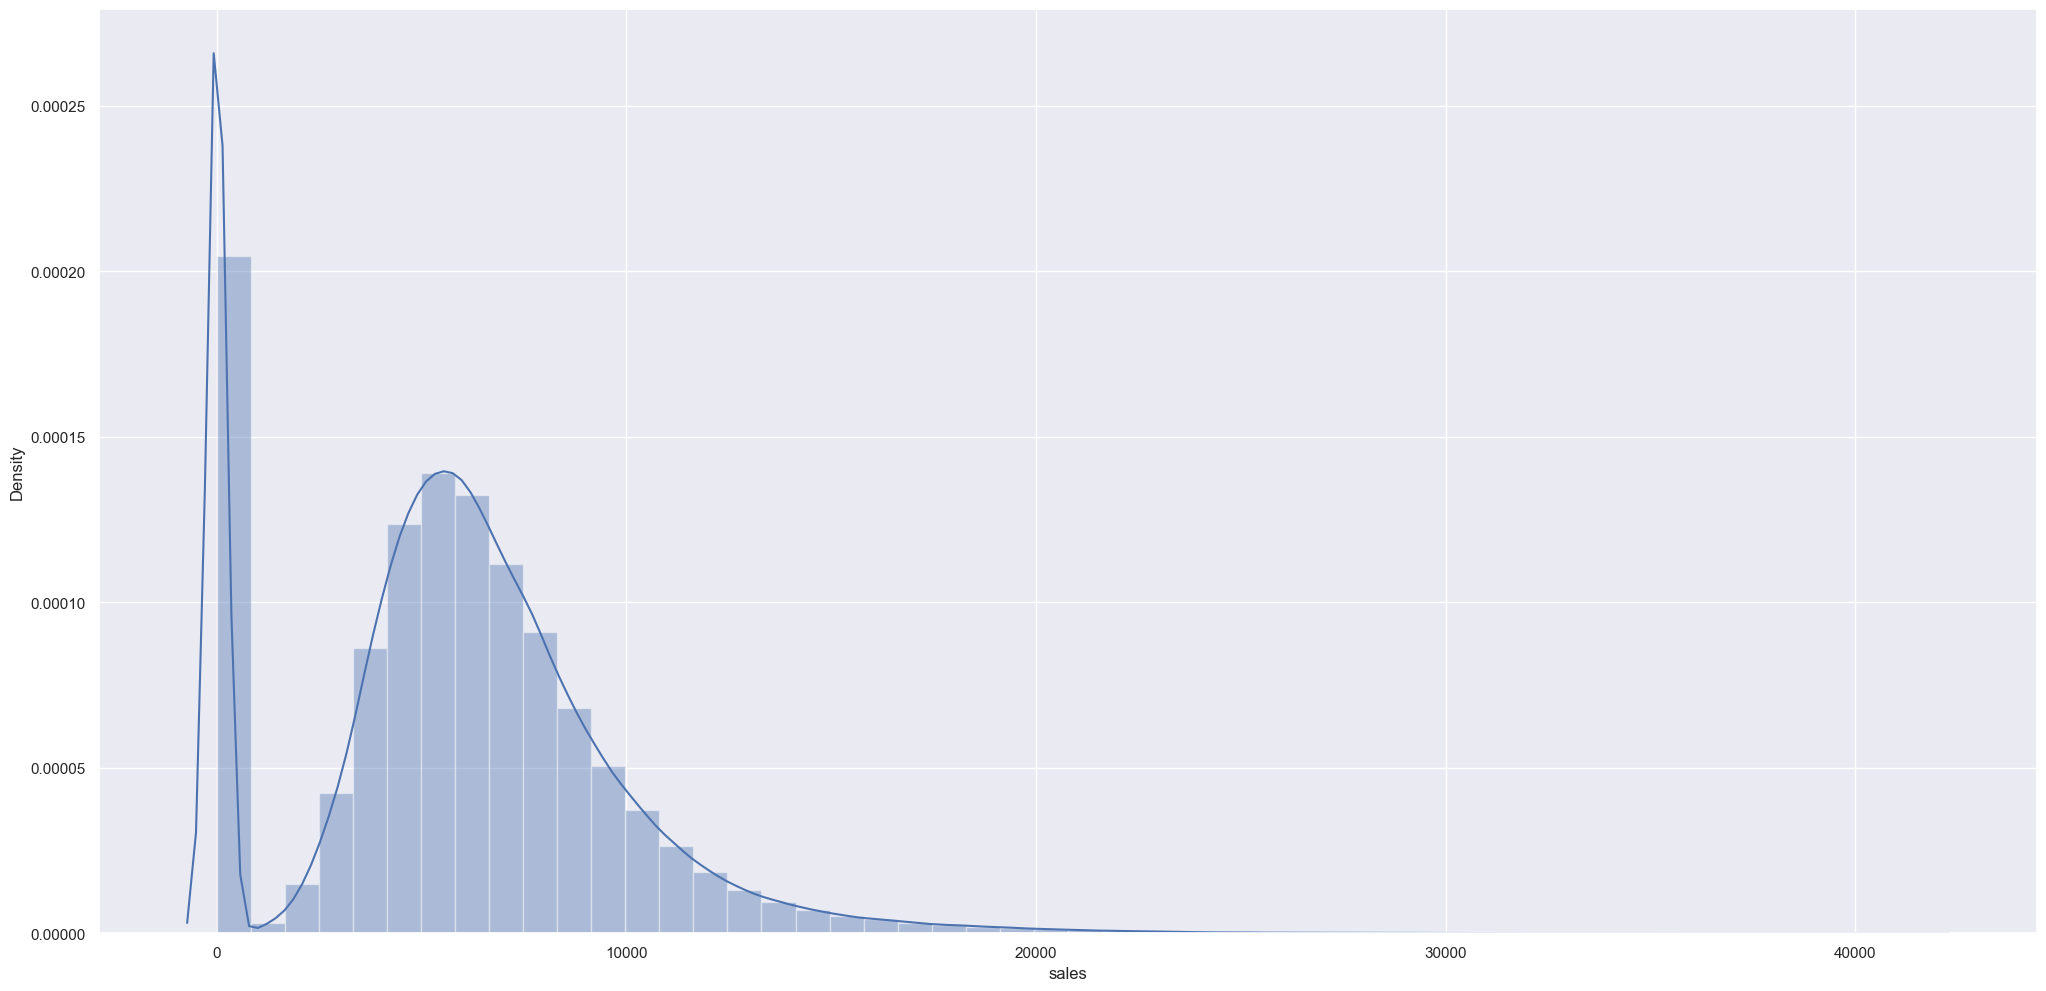

In [21]:
sns.distplot(df1['sales'])

## CATEGORICAL ATTRIBUTES

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

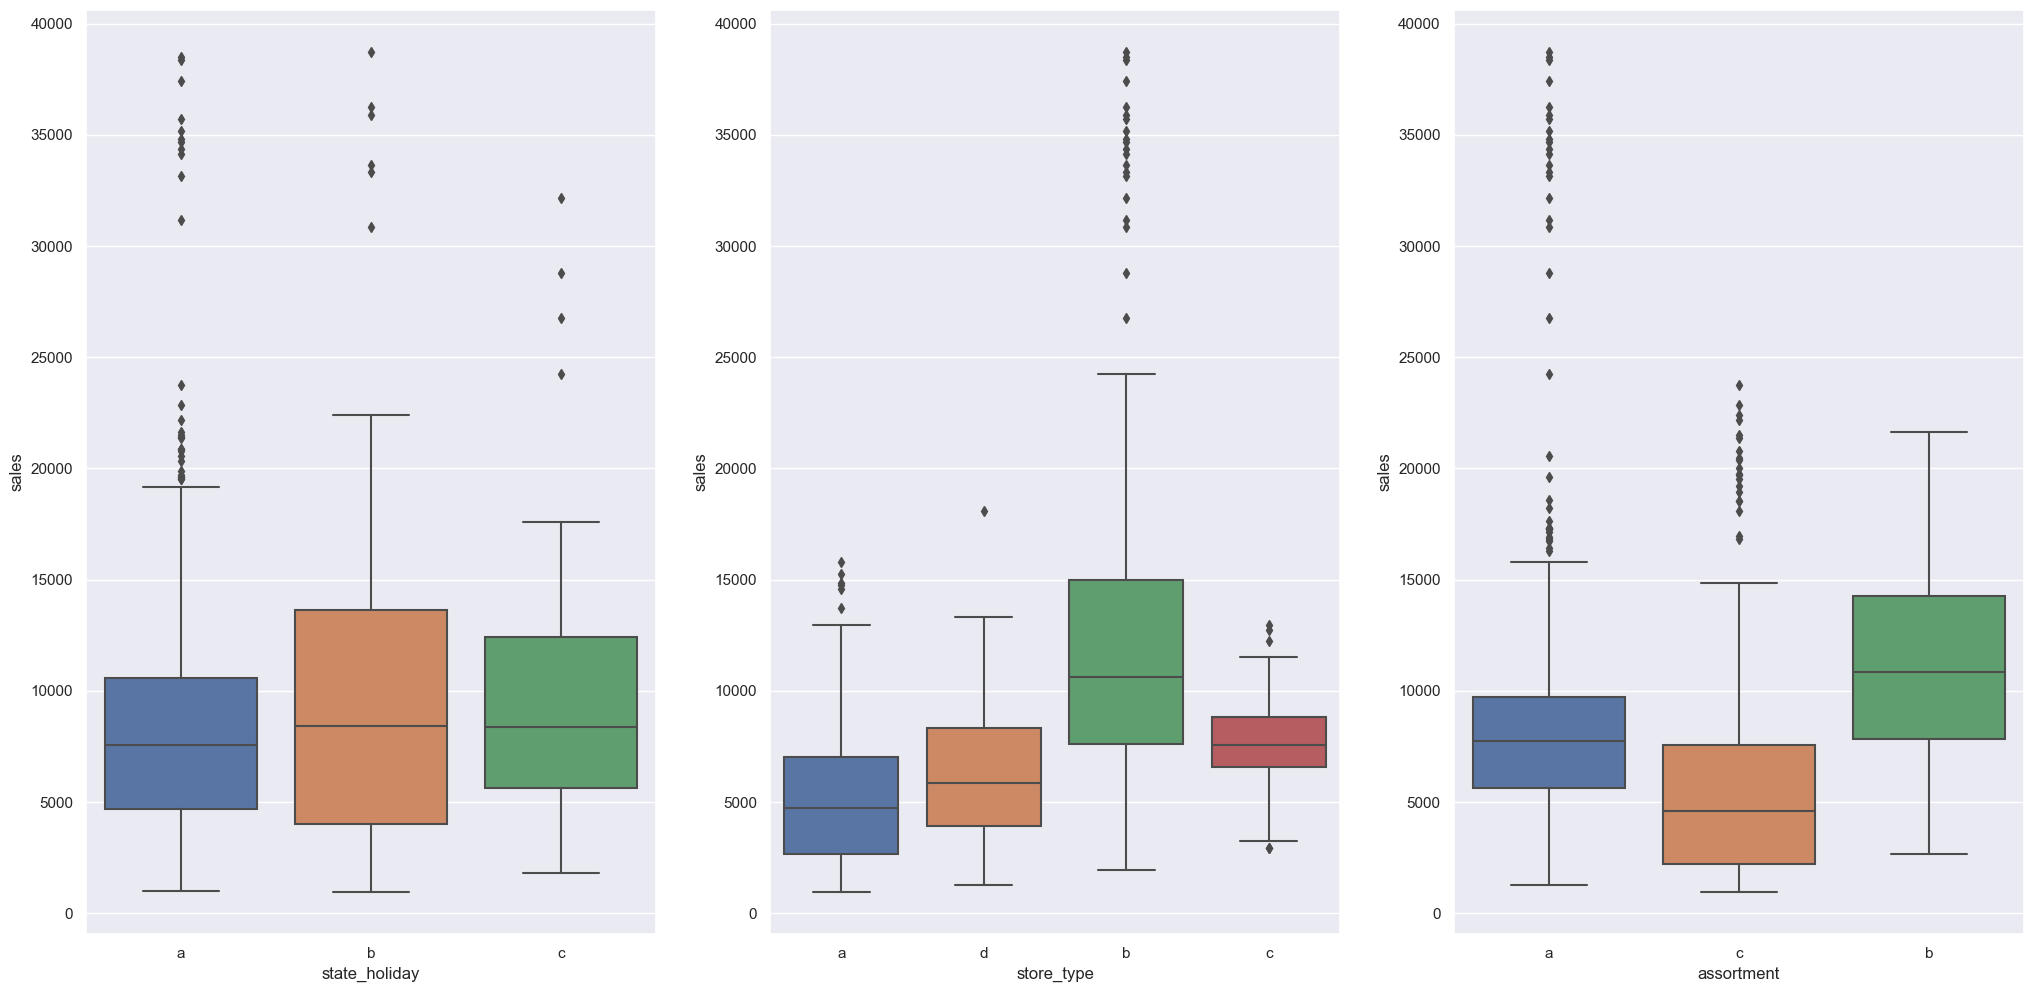

In [23]:
#condições
#'state_holiday != 0' -> dias de loja aberta
#'0' -> pois a coluna se mantem como obj
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#(linha, qtd. grafico, posição)
#1 subplot
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' ,y='sales', data=aux1)

#2 subplot
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' ,y='sales', data=aux1)

#3 subplot
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' ,y='sales', data=aux1)